In [1]:
import os

import math

import numpy as np
import torch

torch.set_default_dtype(torch.double)

import matplotlib.pyplot as plt

In [2]:
fixed_covariance_matrix_path = "../data/DB_10042_fixed_covariance_matrix.npy"
fixed_covariance_matrix = np.load(fixed_covariance_matrix_path)


def calculate_vendi_score(kernel_mat):
    if torch.is_tensor(kernel_mat):
        kernel_mat = kernel_mat.detach().numpy()
    _, s, _ = np.linalg.svd(kernel_mat / kernel_mat.shape[0])

    return np.exp(-(s * np.log(s)).sum())

In [3]:
num_init_queries = 2
num_queries = 100
batch_size = 5

In [4]:
def read_result(path, num_experiments=10):
    train_ind = []
    train_y = []
    for i in range(num_experiments):
        train_ind.append(
            torch.load(os.path.join(path, f"this_train_ind_{i}.pth"))
        )
        
        train_y.append(
            torch.load(os.path.join(path, f"this_train_y_{i}.pth"))
        )

    train_ind = torch.stack(train_ind)
    train_y = torch.stack(train_y)
    
    assert train_ind.size(1) == num_init_queries + num_queries
    assert train_y.size(1) == num_init_queries + num_queries
    
    return train_ind, train_y


styles = ["-", "--", ":", "-."]

def visualize_progress(ax, train_y, name, std_err_multiplier=1, marker="o", color=None):
    xs = torch.arange(train_y.size(1))
    show_ind = xs[(num_init_queries - 1):][::batch_size]
    
    xs = xs[show_ind] - num_init_queries + 1
    # train_y = train_y[:, show_ind]
    
    incumbents = torch.cummax(train_y, dim=1).values[:, show_ind]
    
    mean = incumbents.mean(dim=0)
    std_err = incumbents.std(dim=0) / math.sqrt(train_ind.size(0))
    ax.plot(xs, mean, marker + "-", label=name)
    ax.fill_between(
        xs, 
        mean - std_err_multiplier * std_err, 
        mean + std_err_multiplier * std_err, 
        alpha=0.3,
    )
    
    # for i in range(incumbents.shape[0]):
    #     ax.plot(xs, incumbents[i, :], "o-", c=color)
        
    # ax.legend()
    
    
def visualize_vendi_score(ax, train_ind, name, std_err_multiplier=1, marker="o"):
    xs = torch.arange(train_ind.size(1))
    vendi_scores = torch.zeros_like(train_ind, dtype=torch.double)
    
    for exp_i in range(train_ind.size(0)):
        for eval_i in range(train_ind.size(1)):
            this_train_ind = (
                train_ind[exp_i, :][: (eval_i + 1)].detach().numpy().tolist()
            )
            
            vendi_scores[exp_i, eval_i] = calculate_vendi_score(
                fixed_covariance_matrix[this_train_ind, :][:, this_train_ind]
            )
    
    show_ind = xs[(num_init_queries - 1):][::batch_size]
    xs = xs[show_ind] - num_init_queries + 1
    vendi_scores = vendi_scores[:, show_ind]
            
    mean = vendi_scores.mean(dim=0)
    std_err = vendi_scores.std(dim=0) / math.sqrt(train_ind.size(0))
    
    ax.plot(xs, mean, marker + "-", label=name)
    ax.fill_between(
        xs, 
        mean - std_err_multiplier * std_err, 
        mean + std_err_multiplier * std_err, 
        alpha=0.3,
    )
        
    # ax.legend()

In [5]:
policies = [
    ("vendi_ucb_b_5", "Vendi BayesOpt"),
    ("random", "random search"),
    ("ucb_b_5", "regular BayesOpt"),
]

In [6]:
plt.style.use("seaborn-v0_8-paper")

params = {
    "figure.figsize": (8, 6),
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
}

plt.rcParams.update(params)

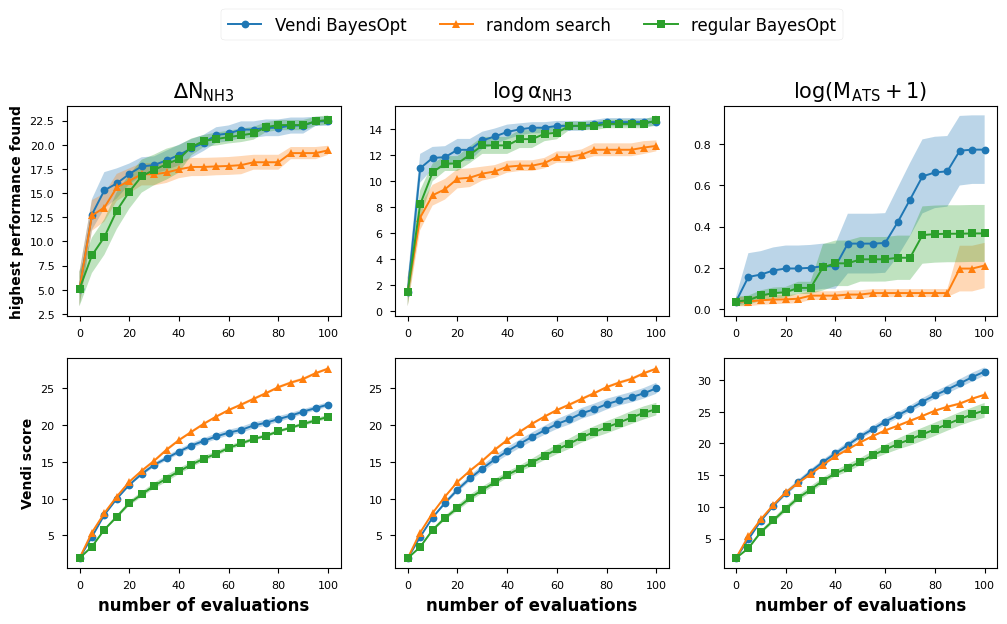

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))

markers = ["o", "^", "s"]

objective_names = [r"${\rm ∆N}_{\rm NH3}$", r"$\log {\rm \alpha}_{\rm NH3}$", r"$\log ({\rm M}_{\rm ATS} + 1)$"]

for target_i, target in enumerate(["M_Storage", "log M_DBD", "log M_Safety+1"]):
    for i, (policy, name) in enumerate(policies):
        path = os.path.join("../data/simulated_runs", target, policy)
        train_ind, train_y = read_result(path)

        visualize_progress(
            ax[0, target_i], 
            train_y, 
            name, 
            std_err_multiplier=1, 
            marker=markers[i],
        )
        visualize_vendi_score(
            ax[1, target_i], 
            train_ind, 
            name, 
            std_err_multiplier=1, 
            marker=markers[i],
        )
    
    # ax[0, target_i].set_title(target, fontsize=13)
    ax[0, target_i].set_title(objective_names[target_i], fontsize=15)
    ax[1, target_i].set_xlabel("number of evaluations", fontweight="bold", fontsize=12)

ax[0, 0].set_ylabel(f"highest performance found", fontweight="bold", fontsize=10)
ax[1, 0].set_ylabel(f"Vendi score", fontweight="bold", fontsize=10)

ax[0, 1].legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.5),
    ncol=3,
    frameon=True,
    fontsize=12,
)

# plt.tight_layout()
plt.show()

0it [00:00, ?it/s]

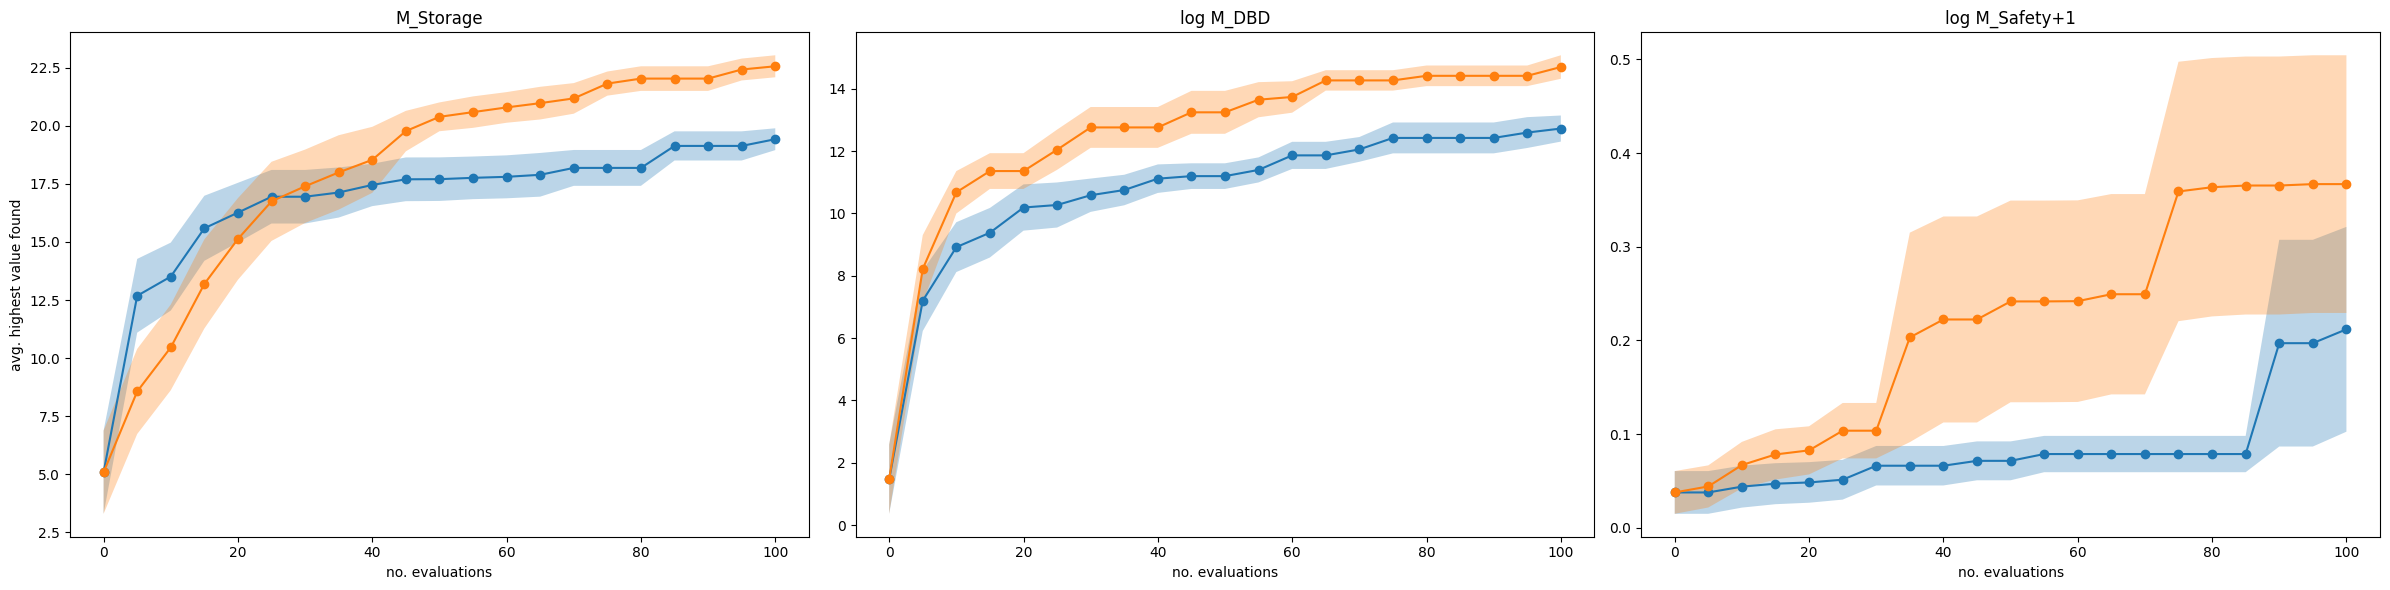

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

for target_i, target in tqdm(enumerate(["M_Storage", "log M_DBD", "log M_Safety+1"])):
    for i, (policy, name) in enumerate(policies):
        path = os.path.join("../data/simulated_runs", target, policy)
        train_ind, train_y = read_result(path)

        visualize_progress(
            ax[target_i], 
            train_y, 
            name, 
            std_err_multiplier=1, 
            color=f"C{i}",
        )
    
    ax[target_i].set_title(target)
    ax[target_i].set_xlabel("no. evaluations")

ax[0].set_ylabel(f"avg. highest value found")

plt.tight_layout()
plt.show()

0it [00:00, ?it/s]

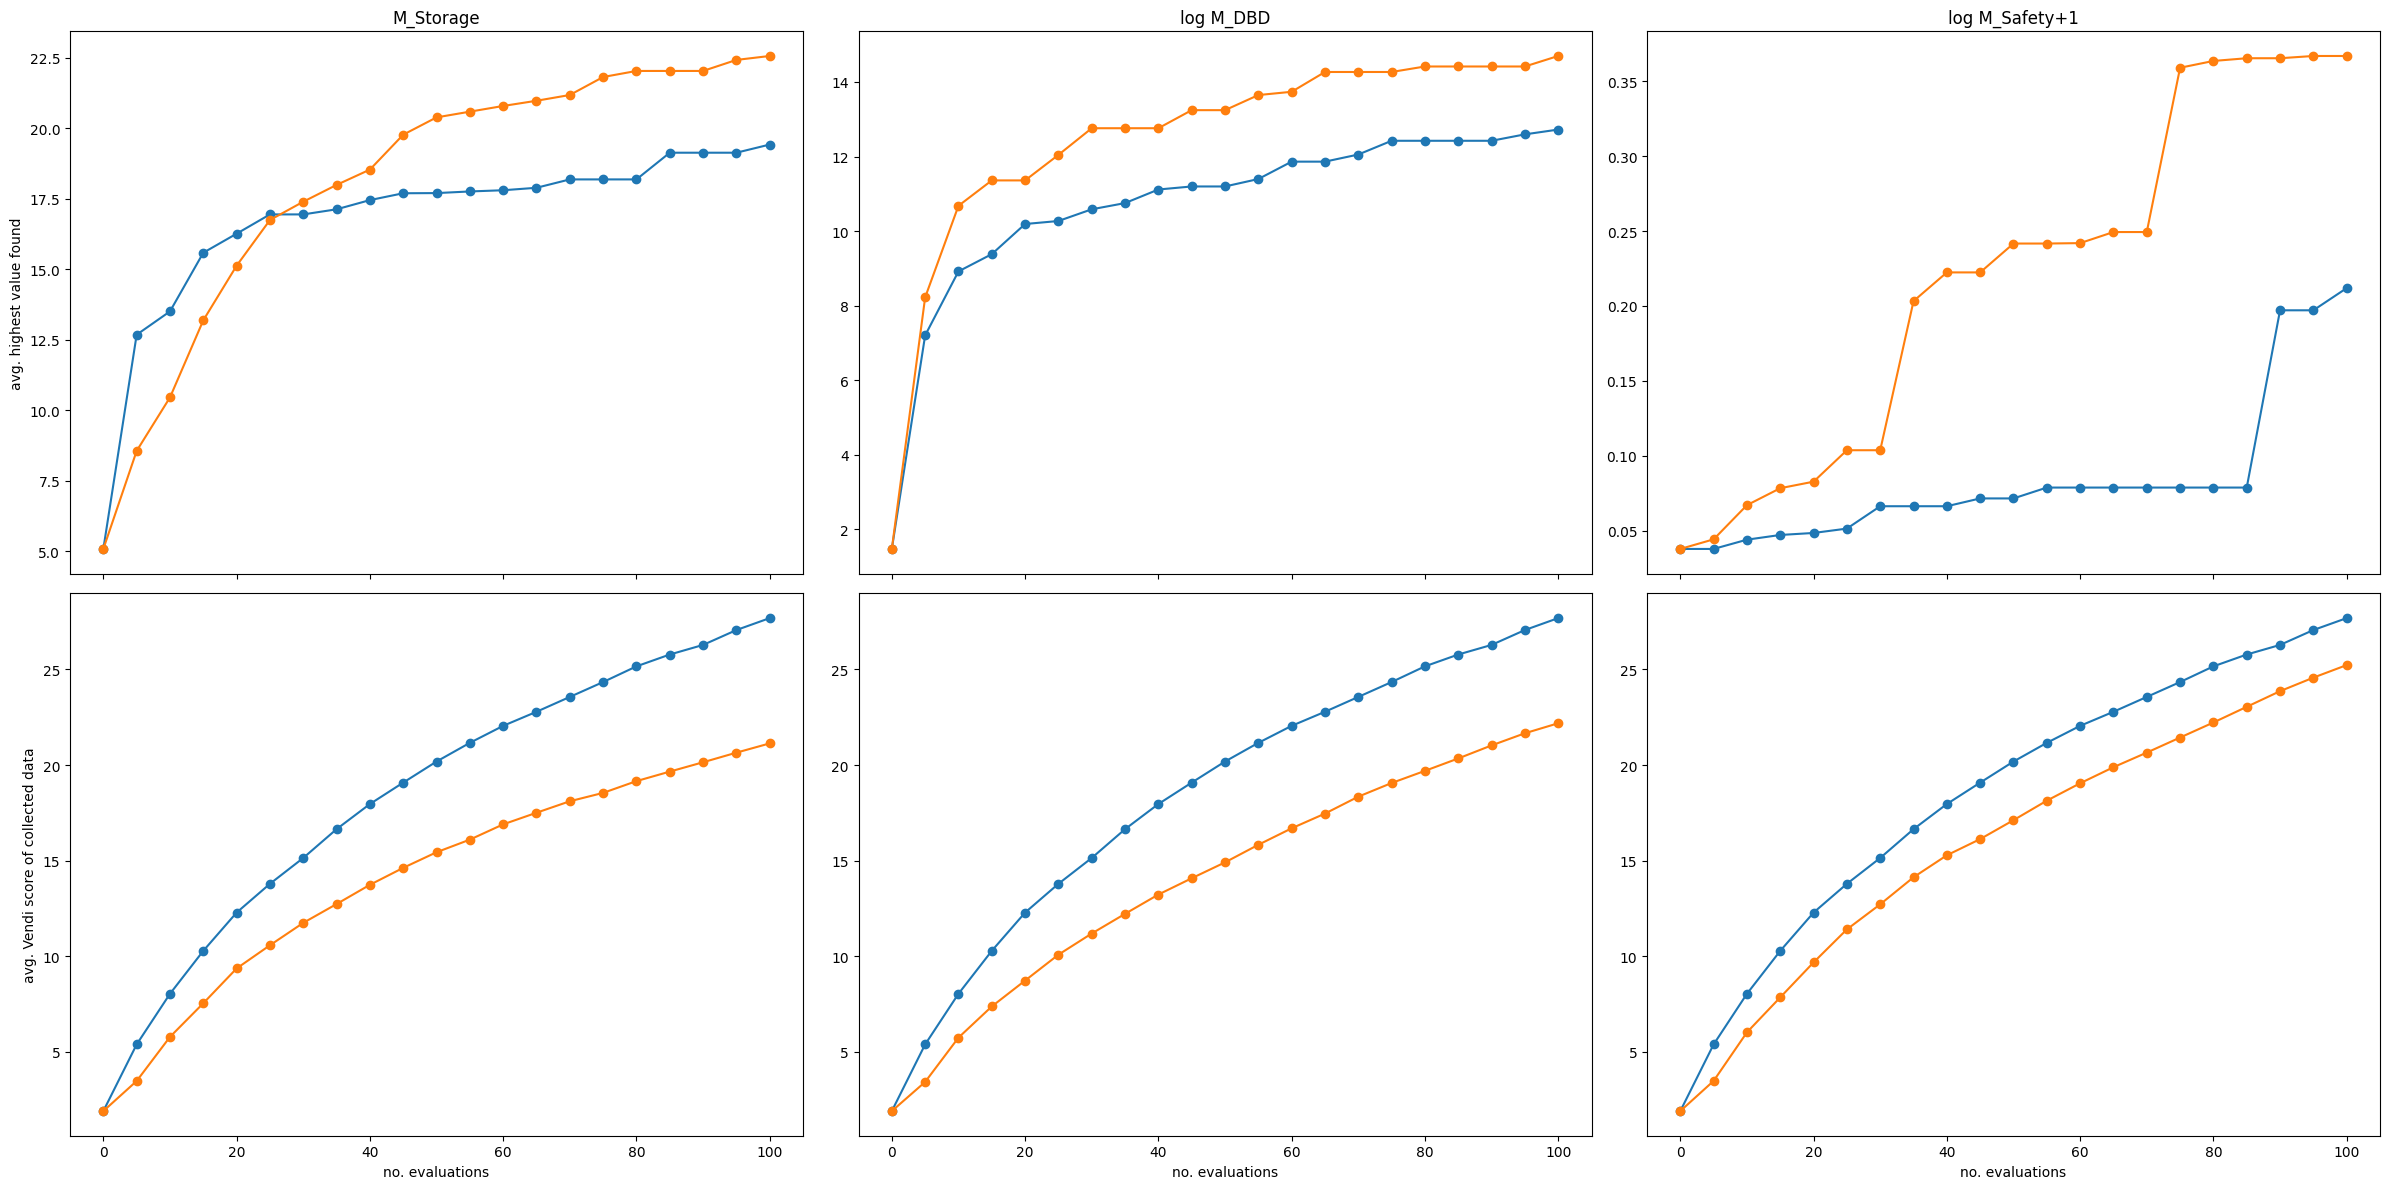

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(24, 12), sharex=True)

for target_i, target in tqdm(enumerate(["M_Storage", "log M_DBD", "log M_Safety+1"])):
    for i, (policy, name) in enumerate(policies):
        path = os.path.join("../data/simulated_runs", target, policy)
        train_ind, train_y = read_result(path)

        visualize_progress(
            ax[0, target_i], train_y, name, std_err_multiplier=0
        )
        visualize_vendi_score(
            ax[1, target_i], train_ind, name, std_err_multiplier=0
        )
    
    ax[0, target_i].set_title(target)
    ax[1, target_i].set_xlabel("no. evaluations")

ax[0, 0].set_ylabel(f"avg. highest value found")
ax[1, 0].set_ylabel(f"avg. Vendi score of collected data")

plt.tight_layout()
plt.show()